# 간단하게 Fashion MNIST를 활용해서 모델을 학습 시키는 코드 with Pytorch

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

from tqdm import tqdm

In [2]:
train_data = datasets.FashionMNIST(
    root = 'data',
    download=True,
    train = True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root = 'data',
    download=True,
    train=False,
    transform=ToTensor()
)

The shape of X : torch.Size([64, 1, 28, 28])
The type of y ": torch.int64


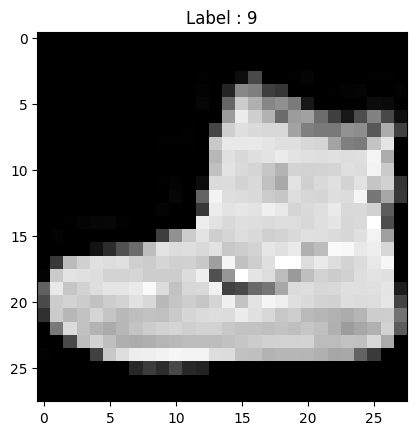

In [3]:
batch_size = 64

train_dataloader = DataLoader(train_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in train_dataloader:
    print(f'The shape of X : {X.shape}')
    print(f'The type of y ": {y.dtype}')

    # 64개의 데이터중에서 가장 처음 데이터를 시각화 한다.
    image = X[0]
    label = y[0]

    if image.shape[0] == 1 :
        image = image.squeeze(0)
    else:
        image = image.permute(1, 2, 0)

    plt.imshow(image, cmap ='gray' if image.ndim == 2 else None)
    plt.title(f'Label : {label}')
    plt.show()

    break



# Feature map 크기 구하기 공식
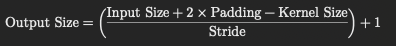

In [4]:
'''
    Feature map 크기 구하기 

    feature map 크기 = ( Input_size - Kernel_size + 2 * padding / stride ) + 1
    아래 코드의 예시 input image의 크기가 28 * 28인경우)

    forward에서의 featuremap 크기 변화
    1) (28 - 3 + 2 * 1) / 1 + 1 = 28 이후 max pooling (2,2) kenerenl = 2, stride = 2 이기에
    28 - 2 + 2 * 0 / 2 + 1  = 14

    2) (14 - 3 + 2 * 1) / 1 + 1 = 14 이후 max pooling을 진행하여 7 * 7 의 feature map이 된다.
    
'''

device = 'cuda' if torch.cuda.is_available() else 'cpu'

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)  # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [5]:
model = CNN().to(device)
print(model)

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [6]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4)

In [7]:
def train(train_dataloader, model, loss_fn, optimizer):
    total_loss = 0
    for X, y in tqdm(train_dataloader, desc = 'Training'):
        X, y = X.to(device), y.to(device)
        # print(f'X의 크기 : {X.shape}')
        pred = model(X)
        loss = loss_fn(pred, y)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        total_loss += loss.item()
    print(f'Average Training loss : {total_loss  / len(train_dataloader)}')

In [8]:
def test(test_dataloader, model, loss_fn):
    model.eval()
    total_loss, correct = 0, 0
    num_samples = 0  # 테스트 샘플의 총 수를 계산하기 위한 변수

    with torch.no_grad():
        for X, y in tqdm(test_dataloader, desc='Testing'):
            X, y = X.to(device), y.to(device)
            pred = model(X)
            loss = loss_fn(pred, y)
            total_loss += loss.item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            num_samples += y.size(0)  # 배치의 샘플 수를 더함

    average_loss = total_loss / len(test_dataloader)  # 평균 손실
    accuracy = correct / num_samples * 100  # 정확도 (퍼센트)

    print(f'Average test loss: {average_loss:.4f}')
    print(f'Accuracy: {accuracy:.2f}%')

In [9]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------


Training:   0%|          | 0/938 [00:00<?, ?it/s]

X의 크기 : torch.Size([64, 1, 28, 28])


Training:   0%|          | 3/938 [00:00<00:33, 28.13it/s]

X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])


Training:   1%|          | 8/938 [00:00<00:24, 38.54it/s]

X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])


Training:   1%|▏         | 13/938 [00:00<00:22, 40.78it/s]

X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])


Training:   2%|▏         | 18/938 [00:00<00:21, 42.63it/s]

X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])


Training:   2%|▏         | 23/938 [00:00<00:20, 44.01it/s]

X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])


Training:   3%|▎         | 28/938 [00:00<00:20, 45.45it/s]

X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])


Training:   4%|▎         | 33/938 [00:00<00:19, 46.80it/s]

X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])


Training:   4%|▍         | 38/938 [00:00<00:18, 47.39it/s]

X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])


Training:   5%|▍         | 43/938 [00:00<00:19, 45.24it/s]

X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])


Training:   5%|▌         | 48/938 [00:01<00:20, 43.62it/s]

X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])


Training:   6%|▌         | 53/938 [00:01<00:20, 42.93it/s]

X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])


Training:   6%|▌         | 58/938 [00:01<00:20, 43.45it/s]

X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])


Training:   7%|▋         | 63/938 [00:01<00:20, 42.54it/s]

X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])


Training:   7%|▋         | 68/938 [00:01<00:20, 41.81it/s]

X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])


Training:   8%|▊         | 73/938 [00:01<00:21, 40.87it/s]

X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])


Training:   8%|▊         | 78/938 [00:01<00:22, 38.37it/s]

X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])


Training:   9%|▉         | 83/938 [00:01<00:21, 39.83it/s]

X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])


Training:   9%|▉         | 88/938 [00:02<00:21, 39.90it/s]

X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])


Training:  10%|▉         | 93/938 [00:02<00:22, 37.16it/s]

X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])


Training:  10%|█         | 98/938 [00:02<00:21, 39.17it/s]

X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])


Training:  11%|█         | 103/938 [00:02<00:20, 41.11it/s]

X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])


Training:  12%|█▏        | 108/938 [00:02<00:19, 42.34it/s]

X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])


Training:  12%|█▏        | 113/938 [00:02<00:18, 43.47it/s]

X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])


Training:  13%|█▎        | 118/938 [00:02<00:18, 43.90it/s]

X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])


Training:  13%|█▎        | 123/938 [00:02<00:18, 43.07it/s]

X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])


Training:  14%|█▎        | 128/938 [00:03<00:18, 44.24it/s]

X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])


Training:  14%|█▍        | 133/938 [00:03<00:18, 44.50it/s]

X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])


Training:  15%|█▍        | 138/938 [00:03<00:17, 45.43it/s]

X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])


Training:  15%|█▌        | 143/938 [00:03<00:17, 45.18it/s]

X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])


Training:  16%|█▌        | 148/938 [00:03<00:17, 45.85it/s]

X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])


Training:  16%|█▋        | 153/938 [00:03<00:17, 45.36it/s]

X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])


Training:  17%|█▋        | 158/938 [00:03<00:18, 41.23it/s]

X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])


Training:  17%|█▋        | 163/938 [00:03<00:18, 42.24it/s]

X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])


Training:  18%|█▊        | 168/938 [00:03<00:17, 43.43it/s]

X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])


Training:  18%|█▊        | 173/938 [00:04<00:17, 44.10it/s]

X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])


Training:  19%|█▉        | 178/938 [00:04<00:17, 43.24it/s]

X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])


Training:  20%|█▉        | 183/938 [00:04<00:17, 42.54it/s]

X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])


Training:  20%|██        | 188/938 [00:04<00:17, 42.99it/s]

X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])


Training:  21%|██        | 193/938 [00:04<00:17, 43.81it/s]

X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])


Training:  21%|██        | 198/938 [00:04<00:16, 44.37it/s]

X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])


Training:  22%|██▏       | 203/938 [00:04<00:16, 44.06it/s]

X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])


Training:  22%|██▏       | 208/938 [00:04<00:16, 43.39it/s]

X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])


Training:  23%|██▎       | 213/938 [00:04<00:16, 44.00it/s]

X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])


Training:  23%|██▎       | 218/938 [00:05<00:18, 39.65it/s]

X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])


Training:  24%|██▍       | 223/938 [00:05<00:18, 39.69it/s]

X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])


Training:  24%|██▍       | 228/938 [00:05<00:17, 39.81it/s]

X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])


Training:  25%|██▍       | 233/938 [00:05<00:17, 39.87it/s]

X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])


Training:  25%|██▌       | 238/938 [00:05<00:17, 40.90it/s]

X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])


Training:  26%|██▌       | 243/938 [00:05<00:17, 39.66it/s]

X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])


Training:  26%|██▋       | 248/938 [00:05<00:17, 40.38it/s]

X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])


Training:  27%|██▋       | 253/938 [00:05<00:16, 41.77it/s]

X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])


Training:  28%|██▊       | 258/938 [00:06<00:15, 42.78it/s]

X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])


Training:  28%|██▊       | 263/938 [00:06<00:15, 42.52it/s]

X의 크기 : torch.Size([64, 1, 28, 28])


Training:  29%|██▊       | 268/938 [00:06<00:15, 42.66it/s]

X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])


Training:  29%|██▉       | 273/938 [00:06<00:17, 38.62it/s]

X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])


Training:  30%|██▉       | 278/938 [00:06<00:16, 40.27it/s]

X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])


Training:  30%|███       | 283/938 [00:06<00:16, 40.72it/s]

X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])


Training:  31%|███       | 288/938 [00:06<00:15, 41.48it/s]

X의 크기 : torch.Size([64, 1, 28, 28])


Training:  31%|███       | 293/938 [00:06<00:15, 41.87it/s]

X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])


Training:  32%|███▏      | 303/938 [00:07<00:14, 43.40it/s]

X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])


Training:  33%|███▎      | 313/938 [00:07<00:14, 44.03it/s]

X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])


Training:  34%|███▍      | 323/938 [00:07<00:13, 44.99it/s]

X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])


Training:  36%|███▌      | 333/938 [00:07<00:13, 44.35it/s]

X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])


Training:  36%|███▌      | 338/938 [00:07<00:13, 44.01it/s]

X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])


Training:  37%|███▋      | 343/938 [00:08<00:13, 44.13it/s]

X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])


Training:  37%|███▋      | 348/938 [00:08<00:14, 42.07it/s]

X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])


Training:  38%|███▊      | 353/938 [00:08<00:13, 42.52it/s]

X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])


Training:  38%|███▊      | 358/938 [00:08<00:14, 38.98it/s]

X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])


Training:  39%|███▊      | 363/938 [00:08<00:14, 40.62it/s]

X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])


Training:  39%|███▉      | 368/938 [00:08<00:13, 41.68it/s]

X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])


Training:  40%|████      | 378/938 [00:08<00:13, 42.21it/s]

X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])


Training:  41%|████      | 383/938 [00:09<00:13, 42.16it/s]

X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])


Training:  41%|████▏     | 388/938 [00:09<00:12, 43.13it/s]

X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])


Training:  42%|████▏     | 393/938 [00:09<00:12, 43.18it/s]

X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])
X의 크기 : torch.Size([64, 1, 28, 28])


Training:  42%|████▏     | 397/938 [00:09<00:12, 42.30it/s]

X의 크기 : torch.Size([64, 1, 28, 28])


KeyboardInterrupt: 

In [ ]:
torch.save(model.state_dict(),'model.pth')
print('Saved PyTorch Model state to model.pth')


In [ ]:
mdoel = CNN().to(device)
model.load_state_dict(torch.load('model.pth'))

In [ ]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]


model.eval()
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    x = x.to(device)
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')